# KNN으로 포지션 예측하기

In [46]:
# Random 값을 정하기 
import numpy as np
np.random.seed(5)

In [47]:
import pandas as pd

In [48]:
train = pd.read_csv('../Data/basketball_train.csv')
test = pd.read_csv('../Data/basketball_test.csv')


In [49]:
train.head()

,Player,Pos,3P,TRB,BLK
0,Allen Crabbe,SG,1.7,2.9,0.3
1,Ian Mahinmi,C,0.0,4.8,0.8
2,Victor Oladipo,SG,1.9,4.3,0.3
3,Austin Rivers,SG,1.5,2.2,0.1
4,Jordan Crawford,SG,1.9,1.8,0.1


In [50]:
test.head()

,Player,Pos,3P,TRB,BLK
0,Evan Fournier,SG,1.9,3.1,0.1
1,Sean Kilpatrick,SG,1.5,4.0,0.1
2,JaVale McGee,C,0.0,3.2,0.9
3,Wayne Ellington,SG,2.4,2.1,0.1
4,Danny Green,SG,1.7,3.3,0.8


In [51]:
print(train.shape)
print(train.count())
print(train.isnull().sum())

(80, 5)
Player    80
Pos       80
3P        80
TRB       80
BLK       80
dtype: int64
Player    0
Pos       0
3P        0
TRB       0
BLK       0
dtype: int64


In [52]:
print(test.shape)
print(test.count())
print(test.isnull().sum())

(20, 5)
Player    20
Pos       20
3P        20
TRB       20
BLK       20
dtype: int64
Player    0
Pos       0
3P        0
TRB       0
BLK       0
dtype: int64


### 최적의 k 찾기 (교차검증 - cross validation)

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score # 교차검증

In [54]:
# 최적의 k를 찾기 위해 교차 검증을 수행할 k의 점위를 3부터 학습데이터의 절반까지 지정
max_k_range = train.shape[0] // 2 
max_k_range

40

In [55]:
# 최적의 k를 찾기 위한 범위 확인
k_list = []
for i in range(3, max_k_range, 2):
  k_list.append(i)

k_list


[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]

In [56]:
# 점수 및 Train Data 정의
cross_validation_scores = []
x_train = train[['3P','BLK','TRB']]
y_train = train['Pos']

print(x_train.head())
print(y_train.head())

    3P  BLK  TRB
0  1.7  0.3  2.9
1  0.0  0.8  4.8
2  1.9  0.3  4.3
3  1.5  0.1  2.2
4  1.9  0.1  1.8
0    SG
1     C
2    SG
3    SG
4    SG
Name: Pos, dtype: object


In [57]:
# 교차검증(10-fold)을 k를 대상으로 수행해 검증 결과를 저장

for k in k_list:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(
    knn, # 모델 이름
    # 각각의 score 낼 필요 없이 cross_val_score 가 해줌
    x_train,
    y_train,
    cv=10, # cross validation(교차검증 횟수)
    scoring='accuracy'

  )
  cross_validation_scores.append(scores.mean())

cross_validation_scores

[0.875,
 0.875,
 0.8875,
 0.9,
 0.9125,
 0.925,
 0.9125,
 0.925,
 0.9125,
 0.9125,
 0.9125,
 0.9,
 0.9,
 0.875,
 0.875,
 0.875,
 0.875,
 0.875,
 0.85]

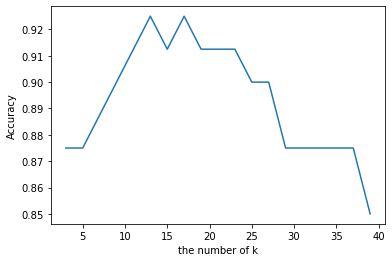

In [58]:
# k에 따른 정확도를 시각화
import matplotlib.pyplot as plt

plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.show()

In [59]:
# 가장 예측률이 높은 k를 선정
cvs = cross_validation_scores
k = k_list[cvs.index(max(cross_validation_scores))]
print("The best number of k is",k)

The best number of k is 13


---
### 2개의 특징으로 예측하기 (3점슛, 블로킹)

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
knn = KNeighborsClassifier(n_neighbors=k)

In [62]:
# 학습에 사용할 features
x_train = train[['3P','BLK']]

In [63]:
# 학습에 사용할 target
y_train = train['Pos']

In [64]:
# 학습시키기
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [65]:
# 검증에 사용할 features
x_test = test[['3P','BLK']]

In [66]:
# 검증의 정담
y_test = test['Pos']

In [67]:
knn.score(x_test, y_test)

1.0

In [68]:
# 예측
pred = knn.predict(x_test)
pred

array(['SG', 'SG', 'C', 'SG', 'SG', 'SG', 'C', 'SG', 'C', 'SG', 'C', 'SG',
       'SG', 'SG', 'SG', 'SG', 'C', 'SG', 'C', 'C'], dtype=object)

In [69]:
# 실제값과 예측값의 비교
comparison = pd.DataFrame(
  {
    '예측값' : pred,
    '정답' : y_test
  }
)

comparison.head()

,예측값,정답
0,SG,SG
1,SG,SG
2,C,C
3,SG,SG
4,SG,SG


### Confusion matrix

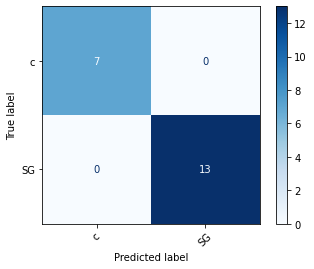

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix1 = confusion_matrix(y_test, pred)
target_names = ["c",'SG']
disp = ConfusionMatrixDisplay(
  confusion_matrix=confusion_matrix1,
  display_labels=target_names
)

disp.plot(
  cmap=plt.cm.Blues,
  xticks_rotation=45
)

plt.show()

---
### 3개의 특징으로 예측하기 (3점슛, 블로킹, 리바운드)

In [74]:
# 학습에 사용할 features
x_train = train[['3P','BLK','TRB']]

In [75]:
# 학습에 사용할 target
y_train = train['Pos']

In [76]:
# 학습시키기
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [77]:
# 검증에 사용할 features
x_test = test[['3P','BLK','TRB']]

In [78]:
# 검증의 정담
y_test = test['Pos']

In [79]:
knn.score(x_test, y_test)

0.9

In [80]:
# 예측
pred = knn.predict(x_test)
pred

array(['SG', 'SG', 'C', 'SG', 'SG', 'SG', 'C', 'SG', 'SG', 'SG', 'C',
       'SG', 'SG', 'SG', 'SG', 'SG', 'C', 'C', 'C', 'C'], dtype=object)

In [81]:
# 실제값과 예측값의 비교
comparison = pd.DataFrame(
  {
    '예측값' : pred,
    '정답' : y_test
  }
)

comparison.head()

,예측값,정답
0,SG,SG
1,SG,SG
2,C,C
3,SG,SG
4,SG,SG


### Confusion matrix

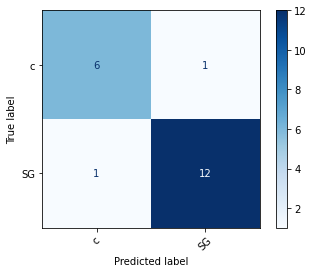

In [82]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix1 = confusion_matrix(y_test, pred)
target_names = ["c",'SG']
disp = ConfusionMatrixDisplay(
  confusion_matrix=confusion_matrix1,
  display_labels=target_names
)

disp.plot(
  cmap=plt.cm.Blues,
  xticks_rotation=45
)

plt.show()

In [86]:
print(knn.predict([[3.4,0.5,3.7]]))

['SG']
